# Installing Whisper

The commands below will install the Python packages needed to use Whisper models and evaluate the transcription results.

# Loading the LibriSpeech dataset

The following will load the test-clean split of the LibriSpeech corpus using torchaudio.

In [1]:
import os
os.chdir(r'C:\\work\\Github\\whisper')
os.getcwd()

'C:\\work\\Github\\whisper'

In [2]:
import os
import numpy as np

try:
    import tensorflow  # required in Colab to avoid protobuf compatibility issues
except ImportError:
    pass

import torch
import pandas as pd
import whisper
import torchaudio

from tqdm.notebook import tqdm


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
class LibriSpeech(torch.utils.data.Dataset):
    """
    A simple class to wrap LibriSpeech and trim/pad the audio to 30 seconds.
    It will drop the last few seconds of a very small portion of the utterances.
    """
    def __init__(self, split="test-clean", device=DEVICE):
        self.dataset = torchaudio.datasets.LIBRISPEECH(
            root=os.path.expanduser("~/.cache"),
            url=split,
            download=True,
        )
        self.device = device

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, item):
        audio, sample_rate, text, _, _, _ = self.dataset[item]
        assert sample_rate == 16000
        audio = whisper.pad_or_trim(audio.flatten()).to(self.device)
        mel = whisper.log_mel_spectrogram(audio)
        
        return (mel, text)

In [6]:
dataset = LibriSpeech("test-clean")
loader = torch.utils.data.DataLoader(dataset, batch_size=16)

# Running inference on the dataset using a base Whisper model

The following will take a few minutes to transcribe all utterances in the dataset.

In [5]:
model = whisper.load_model("base.en")
print(
    f"Model is {'multilingual' if model.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model.parameters()):,} parameters."
)

Model is English-only and has 71,825,408 parameters.


In [9]:
# predict without timestamps for short-form transcription
options = whisper.DecodingOptions(language="en", without_timestamps=True, fp16 = False)

In [16]:
%%time
hypotheses = []
references = []

for mels, texts in tqdm(loader):
    results = model.decode(mels, options)
    hypotheses.extend([result.text for result in results])
    references.extend(texts)
    

  0%|          | 0/164 [00:00<?, ?it/s]

CPU times: total: 8h 34min 11s
Wall time: 3h 40s


In [17]:
data = pd.DataFrame(dict(hypothesis=hypotheses, reference=references))
data

,hypothesis,reference
0,"He hoped there would be stew for dinner, turni...",HE HOPED THERE WOULD BE STEW FOR DINNER TURNIP...
1,"Stuffered into you, his belly counseled him.",STUFF IT INTO YOU HIS BELLY COUNSELLED HIM
2,After early nightfall the yellow lamps would l...,AFTER EARLY NIGHTFALL THE YELLOW LAMPS WOULD L...
3,"Hello Bertie, any good in your mind?",HELLO BERTIE ANY GOOD IN YOUR MIND
4,Number 10. Fresh Nelly is waiting on you. Good...,NUMBER TEN FRESH NELLY IS WAITING ON YOU GOOD ...
...,...,...
2615,"Oh, to shoot my soul's full meaning into futur...",OH TO SHOOT MY SOUL'S FULL MEANING INTO FUTURE...
2616,"Then I, long tried by natural ills, received t...",THEN I LONG TRIED BY NATURAL ILLS RECEIVED THE...
2617,I love thee freely as men strive for right. I ...,I LOVE THEE FREELY AS MEN STRIVE FOR RIGHT I L...
2618,"I love thee with the passion put to use, in my...",I LOVE THEE WITH THE PASSION PUT TO USE IN MY ...


# Calculating the word error rate

Now, we use our English normalizer implementation to standardize the transcription and calculate the WER.

In [18]:
import jiwer
from whisper.normalizers import EnglishTextNormalizer

normalizer = EnglishTextNormalizer()

In [19]:
data["hypothesis_clean"] = [normalizer(text) for text in data["hypothesis"]]
data["reference_clean"] = [normalizer(text) for text in data["reference"]]
data

,hypothesis,reference,hypothesis_clean,reference_clean
0,"He hoped there would be stew for dinner, turni...",HE HOPED THERE WOULD BE STEW FOR DINNER TURNIP...,he hoped there would be stew for dinner turnip...,he hoped there would be stew for dinner turnip...
1,"Stuffered into you, his belly counseled him.",STUFF IT INTO YOU HIS BELLY COUNSELLED HIM,stuffered into you his belly counseled him,stuff it into you his belly counseled him
2,After early nightfall the yellow lamps would l...,AFTER EARLY NIGHTFALL THE YELLOW LAMPS WOULD L...,after early nightfall the yellow lamps would l...,after early nightfall the yellow lamps would l...
3,"Hello Bertie, any good in your mind?",HELLO BERTIE ANY GOOD IN YOUR MIND,hello bertie any good in your mind,hello bertie any good in your mind
4,Number 10. Fresh Nelly is waiting on you. Good...,NUMBER TEN FRESH NELLY IS WAITING ON YOU GOOD ...,number 10 fresh nelly is waiting on you good n...,number 10 fresh nelly is waiting on you good n...
...,...,...,...,...
2615,"Oh, to shoot my soul's full meaning into futur...",OH TO SHOOT MY SOUL'S FULL MEANING INTO FUTURE...,0 to shoot my soul is full meaning into future...,0 to shoot my soul is full meaning into future...
2616,"Then I, long tried by natural ills, received t...",THEN I LONG TRIED BY NATURAL ILLS RECEIVED THE...,then i long tried by natural ills received the...,then i long tried by natural ills received the...
2617,I love thee freely as men strive for right. I ...,I LOVE THEE FREELY AS MEN STRIVE FOR RIGHT I L...,i love thee freely as men strive for right i l...,i love thee freely as men strive for right i l...
2618,"I love thee with the passion put to use, in my...",I LOVE THEE WITH THE PASSION PUT TO USE IN MY ...,i love thee with the passion put to use in my ...,i love thee with the passion put to use in my ...


In [15]:
wer = jiwer.wer(list(data["reference_clean"]), list(data["hypothesis_clean"]))

print(f"WER: {wer * 100:.2f} %")

WER: 3.37 %


In [65]:
audio, sample_rate, text, _, _, _  = dataset.dataset[10]


In [66]:
%%time
hypotheses = []
print(type(audio), audio.shape, f"{audio.shape[1]/16000}")
w_audio = whisper.pad_or_trim(audio.flatten())
print(type(w_audio), w_audio.shape)
mel = whisper.log_mel_spectrogram(w_audio)
print(type(mel), mel.shape)
results = model.decode(mel, options)
print(f"|{results.text}|")

<class 'torch.Tensor'> torch.Size([1, 70480]) 4.405
<class 'torch.Tensor'> torch.Size([480000])
<class 'torch.Tensor'> torch.Size([80, 3000])
|Well now Ennis, I declare you have a head and so has my stick.|
CPU times: total: 3.34 s
Wall time: 1.33 s


#  try different models

In [3]:
model_tiny = whisper.load_model("tiny")
print(
    f"Model is {'multilingual' if model_tiny.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model_tiny.parameters()):,} parameters."
)

Model is multilingual and has 37,184,640 parameters.


In [10]:
%%time
audio, sample_rate, text, _, _, _  = dataset.dataset[0]

hypotheses = []
print(type(audio), audio.shape, f"{audio.shape[1]/16000}")
w_audio = whisper.pad_or_trim(audio.flatten())
print(type(w_audio), w_audio.shape)
mel = whisper.log_mel_spectrogram(w_audio)
print(type(mel), mel.shape)
results = model_tiny.decode(mel, options)
#hypotheses.extend([result.text for result in results])
print(f"|{results.text}|")

<class 'torch.Tensor'> torch.Size([1, 166960]) 10.435
<class 'torch.Tensor'> torch.Size([480000])
<class 'torch.Tensor'> torch.Size([80, 3000])
|He hoped there would be stew for dinner, turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick, peppered flour-fat and sauce.|
CPU times: total: 2.52 s
Wall time: 1.24 s


# load and transcribe local file (16Khz)

In [11]:
import librosa
def load_wav_to_tensor(file_path):
    # Load the WAV file using librosa
    waveform, sample_rate = librosa.load(file_path, sr=None, mono=True)

    # Convert the waveform to a torch tensor
    tensor_waveform = torch.tensor(waveform).unsqueeze(0)

    return tensor_waveform, sample_rate

# Example usage
file_path = r"C:\work\local4test\sampleAudio\shortTestRecording.wav"
audio, sample_rate = load_wav_to_tensor(file_path)

print(type(audio), audio.shape, sample_rate)

<class 'torch.Tensor'> torch.Size([1, 262640]) 16000


In [13]:
%%time

hypotheses = []
print(type(audio), audio.shape, f"{audio.shape[1]/16000}")
w_audio = whisper.pad_or_trim(audio.flatten())
print(type(w_audio), w_audio.shape)
mel = whisper.log_mel_spectrogram(w_audio)
print(type(mel), mel.shape)
results = model_tiny.decode(mel, options)
#hypotheses.extend([result.text for result in results])
print(f"|{results.text}|")

<class 'torch.Tensor'> torch.Size([1, 262640]) 16.415
<class 'torch.Tensor'> torch.Size([480000])
<class 'torch.Tensor'> torch.Size([80, 3000])
|Testing 16kHz 16bts creating a PCM to see what the recognition gives us a short message for testing.|
CPU times: total: 1.59 s
Wall time: 746 ms


# [decode code ](https://github.com/openai/whisper/blob/main/whisper/decoding.py)


# fast decode

https://github.com/openai/whisper/discussions/937
https://github.com/guillaumekln/faster-whisper

# [exploring OpenAI](https://deepgram.com/learn/exploring-whisper) 

https://github.com/huggingface/transformers/issues/22612



In [20]:
# predict without timestamps for short-form transcription
options = whisper.DecodingOptions(language="en", 
                                  without_timestamps=False, 
                                  fp16 = False,
                                  beam_size=5)

In [21]:
%%time

hypotheses = []
print(type(audio), audio.shape, f"{audio.shape[1]/16000}")
w_audio = whisper.pad_or_trim(audio.flatten())
print(type(w_audio), w_audio.shape)
mel = whisper.log_mel_spectrogram(w_audio)
print(type(mel), mel.shape)
results = model_tiny.decode(mel, options)
#hypotheses.extend([result.text for result in results])
print(f"|{results.text}|")

<class 'torch.Tensor'> torch.Size([1, 262640]) 16.415
<class 'torch.Tensor'> torch.Size([480000])
<class 'torch.Tensor'> torch.Size([80, 3000])
|Testing 16 kilohertz, 16 bits, creating a PCM to see what the recognition gives us, a short message for testing.|
CPU times: total: 3.75 s
Wall time: 1.55 s


In [22]:
results

DecodingResult(audio_features=tensor([[ 7.5767e-02,  7.8927e-02,  5.5705e-02,  ..., -6.9763e-03,
          9.4853e-02,  2.2575e-03],
        [-8.7031e-01,  1.1955e+00,  4.1717e-01,  ...,  4.8742e-01,
          5.0555e-01,  3.0571e-01],
        [-6.2020e-02,  2.4890e+00,  9.6831e-01,  ..., -9.5492e-02,
          3.6553e-03,  6.0695e-01],
        ...,
        [ 8.1028e-01, -1.8153e+00,  2.2517e-01,  ..., -1.7392e-01,
         -5.4939e-01,  4.6533e-01],
        [-1.4586e-01, -5.0648e-01,  9.0076e-02,  ...,  6.1381e-01,
         -4.4479e-03,  2.4431e-01],
        [ 1.9533e-01, -1.4203e-01, -1.4317e+00,  ...,  1.2032e-01,
         -4.8694e-01, -1.7339e-01]]), language='en', language_probs=None, tokens=[50364, 45517, 3165, 21112, 35655, 11, 3165, 9239, 11, 4084, 257, 6465, 44, 281, 536, 437, 264, 11150, 2709, 505, 11, 257, 2099, 3636, 337, 4997, 13, 50964], text='Testing 16 kilohertz, 16 bits, creating a PCM to see what the recognition gives us, a short message for testing.', avg_logprob=-0.

# [silero-vad](https://github.com/snakers4/silero-vad)

In [73]:
# https://colab.research.google.com/github/snakers4/silero-vad/blob/master/silero-vad.ipynb#scrollTo=pSifus5IilRp

#https://github.com/snakers4/silero-vad/blob/master/utils_vad.py


In [14]:
from IPython.display import Audio
from pprint import pprint
import librosa
import librosa.display
import matplotlib.pyplot as plt


C:\Users\tzurv\.conda\envs\whisper\Lib\site-packages\lazy_loader\__init__.py:185: RuntimeWarning: subpackages can technically be lazily loaded, but it causes the package to be eagerly loaded even if it is already lazily loaded.So, you probably shouldn't use subpackages with this lazy feature.
  warnings.warn(msg, RuntimeWarning)
C:\Users\tzurv\.conda\envs\whisper\Lib\site-packages\lazy_loader\__init__.py:185: RuntimeWarning: subpackages can technically be lazily loaded, but it causes the package to be eagerly loaded even if it is already lazily loaded.So, you probably shouldn't use subpackages with this lazy feature.
  warnings.warn(msg, RuntimeWarning)


In [15]:
USE_ONNX = False # change this to True if you want to test onnx model
model, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=True,
                              onnx=USE_ONNX)


Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to C:\Users\tzurv/.cache\torch\hub\master.zip


In [16]:
(get_speech_timestamps,
 save_audio,
 read_audio,
 VADIterator,
 collect_chunks) = utils

In [17]:
SAMPLING_RATE = 16000

In [19]:
wav = read_audio(file_path, sampling_rate=SAMPLING_RATE)
# get speech timestamps from full audio file
speech_timestamps = get_speech_timestamps(wav, model, sampling_rate=SAMPLING_RATE, visualize_probs=False)
pprint(speech_timestamps)

[{'end': 16864, 'start': 4128}, {'end': 203744, 'start': 18976}]


In [87]:
wav.shape

torch.Size([262640])

In [83]:
for seg in speech_timestamps:
    print(f"{seg['start']/SAMPLING_RATE} to {seg['end']/SAMPLING_RATE}")

0.258 to 1.054
1.186 to 12.734


In [95]:
plt.close()
#plt.figure(figsize=(10, 4))
librosa.display.waveshow(wav.numpy(), sr=SAMPLING_RATE)
#plt.xlabel("Time (s)")
#plt.ylabel("Amplitude")
#plt.title("Audio Waveform")
#plt.tight_layout()
#plt.show()


<Figure size 1000x400 with 0 Axes>

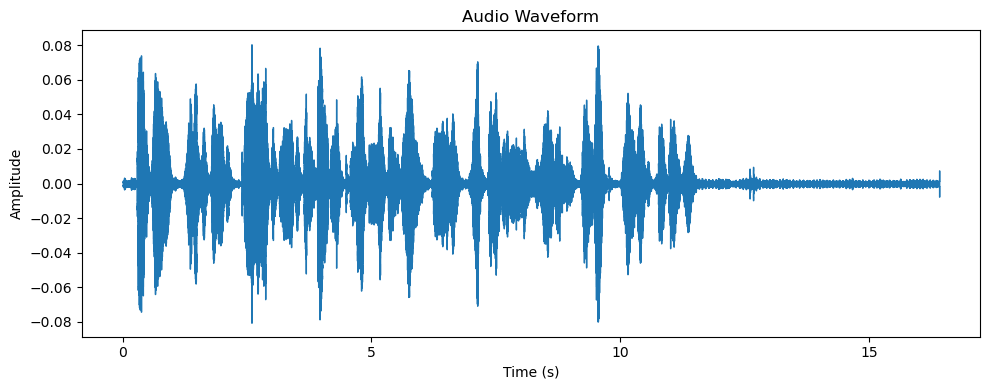

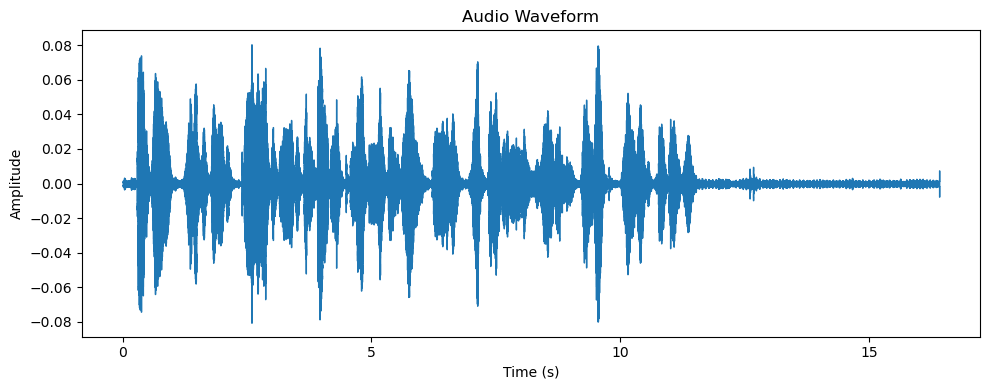

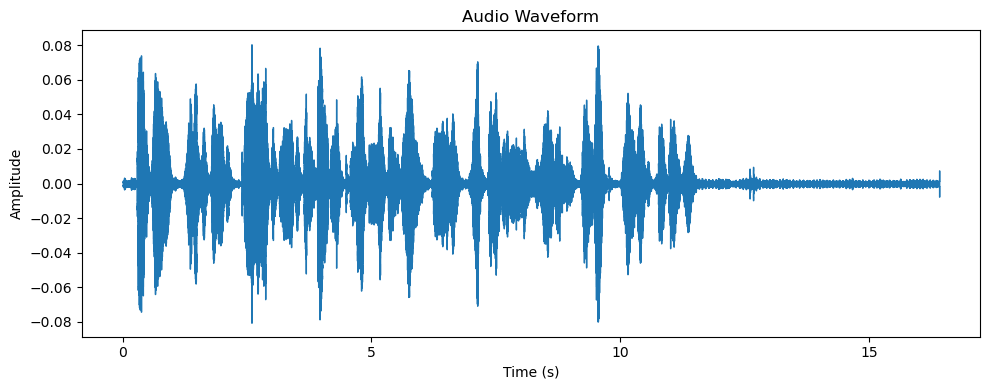

<Figure size 1000x400 with 0 Axes>

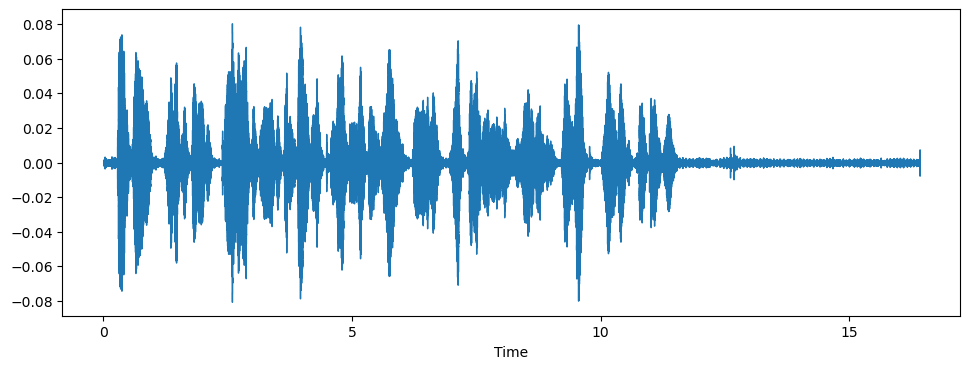

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [97]:
plt.show()

AttributeError: module 'matplotlib' has no attribute 'axes'

<Figure size 1000x400 with 0 Axes>

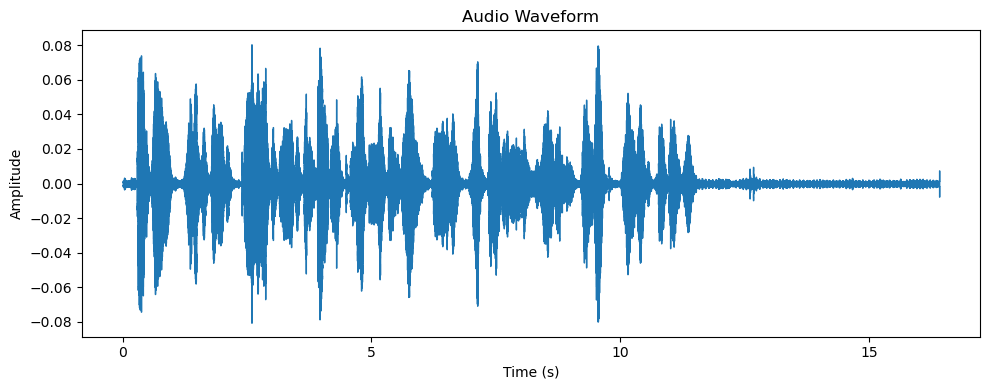

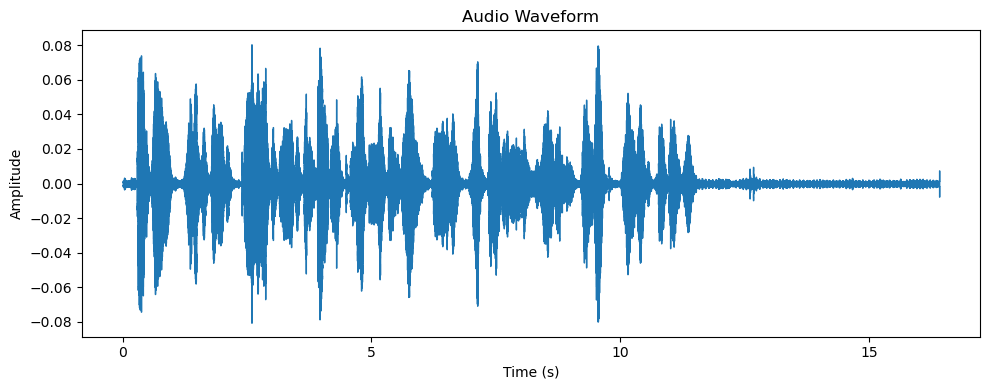

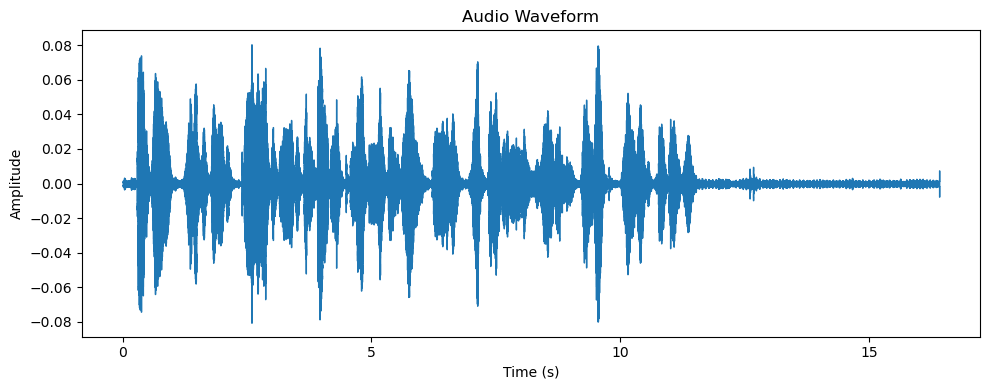

<Figure size 1000x400 with 0 Axes>

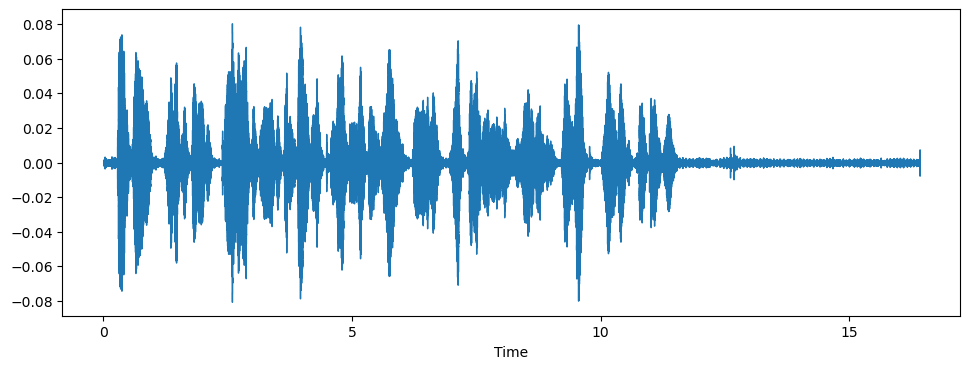

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [99]:
y, sr = librosa.load(librosa.ex('choice'), duration=10)
fig, ax = plt.subplots(nrows=1, sharex=True)
librosa.display.waveshow(wav.numpy(), sr=SAMPLING_RATE, ax=ax[0])
ax[0].set(title='Envelope view, mono')
ax[0].label_outer()

# Games

In [23]:
import torch
from torch.distributions import Categorical

# Create a tensor of logits (unnormalized probabilities)
logits = torch.tensor([1.0, 2.0, 3.0])

# Create a Categorical distribution
distribution = Categorical(logits=logits)

# Sample from the distribution
sample = distribution.sample()  # Returns an index (0, 1, or 2)

# Compute the log probability of a specific value (e.g., index 2)
log_prob = distribution.log_prob(2)

ValueError: The value argument to log_prob must be a Tensor

In [48]:
import torch
from torch.distributions import Categorical

# Create a tensor of logits (unnormalized probabilities)
logits = torch.tensor([0.1, 1.0, 2.0, 3.0, 5.0 , 6.1])

# Create a Categorical distribution
distribution = Categorical(logits=logits)

# Sample from the distribution
sample = distribution.sample()  # Returns an index (0, 1, or 2)

# Compute the log probability of a specific value (e.g., index 2)
value = torch.tensor(2)
log_prob = distribution.log_prob(value)

print("Sampled index:", sample.item())
print("Log probability of index 2:", log_prob.item())

Sampled index: 5
Log probability of index 2: -4.438661575317383
